In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.inspection import permutation_importance
from sklearn.utils import compute_sample_weight
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report, roc_curve
)

import joblib
import warnings
warnings.filterwarnings("ignore")

CSV_PATH = "earthquake_data_tsunami2.csv"
TARGET_COL = "tsunami"
IGNORED_COLS = ["Year", "Month", "dmin", "gap", "nst"]
RANDOM_STATE = 42


In [59]:
# Import Dataset and Select Features

df = pd.read_csv(CSV_PATH)

print("Shape:", df.shape)
print("Columns:", list(df.columns))

df.head()

FEATURE_COLS = [c for c in df.columns if c != TARGET_COL and c not in IGNORED_COLS]

X = df[FEATURE_COLS]
y = df[TARGET_COL].astype(int)

print("Target distribution:\n", y.value_counts(normalize=True))

X.isna().sum()

Shape: (782, 13)
Columns: ['magnitude', 'cdi', 'mmi', 'sig', 'nst', 'dmin', 'gap', 'depth', 'latitude', 'longitude', 'Year', 'Month', 'tsunami']
Target distribution:
 tsunami
0    0.663683
1    0.336317
Name: proportion, dtype: float64


magnitude    0
cdi          0
mmi          0
sig          0
depth        0
latitude     0
longitude    0
dtype: int64

In [34]:
#Train/Test Split and create Pipeline

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=RANDOM_STATE, stratify=y
)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)

pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("clf", HistGradientBoostingClassifier(random_state=RANDOM_STATE))
])

sample_weight_train = compute_sample_weight(class_weight="balanced", y=y_train)

Train shape: (625, 7)
Test shape: (157, 7)


In [35]:
#Hyperparameter Search

param_distributions = {
    "clf__learning_rate": np.logspace(-3, -0.3, 20),
    "clf__max_iter": [100, 200, 300, 400, 600],
    "clf__max_depth": [3, 5, 7, None],
    "clf__min_samples_leaf": [1, 5, 10, 20],
    "clf__l2_regularization": [0.0, 0.01, 0.1, 1.0],
    "clf__max_bins": [63, 127, 255],
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

rs = RandomizedSearchCV(
    pipeline,
    param_distributions=param_distributions,
    n_iter=40,
    scoring="roc_auc",
    n_jobs=-1,
    cv=cv,
    random_state=RANDOM_STATE,
    verbose=2,
)

rs.fit(X_train, y_train, clf__sample_weight=sample_weight_train)

print("Best ROC AUC:", rs.best_score_)
print("Best Params:", rs.best_params_)

Fitting 5 folds for each of 40 candidates, totalling 200 fits
Best ROC AUC: 0.7738955823293172
Best Params: {'clf__min_samples_leaf': 10, 'clf__max_iter': 400, 'clf__max_depth': 5, 'clf__max_bins': 127, 'clf__learning_rate': 0.009879542688342922, 'clf__l2_regularization': 0.1}


In [36]:
#Evaluate Test Set

best_model = rs.best_estimator_

y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1:", f1_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))

print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
cm

Accuracy: 0.7643312101910829
Precision: 0.6428571428571429
Recall: 0.6792452830188679
F1: 0.6605504587155964
ROC AUC: 0.7886429608127722

Classification Report:

              precision    recall  f1-score   support

           0       0.83      0.81      0.82       104
           1       0.64      0.68      0.66        53

    accuracy                           0.76       157
   macro avg       0.74      0.74      0.74       157
weighted avg       0.77      0.76      0.77       157



array([[84, 20],
       [17, 36]], dtype=int64)

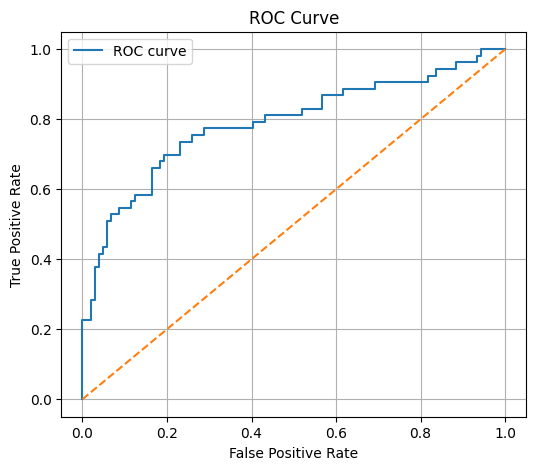

In [37]:
#Graph Effectiveness of Binary Classification

fpr, tpr, thresholds = roc_curve(y_test, y_proba)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label="ROC curve")
plt.plot([0,1],[0,1],'--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid()
plt.show()

depth        0.078344
longitude    0.042675
magnitude    0.019108
sig          0.019108
latitude     0.012739
cdi          0.001274
mmi         -0.006369
dtype: float64

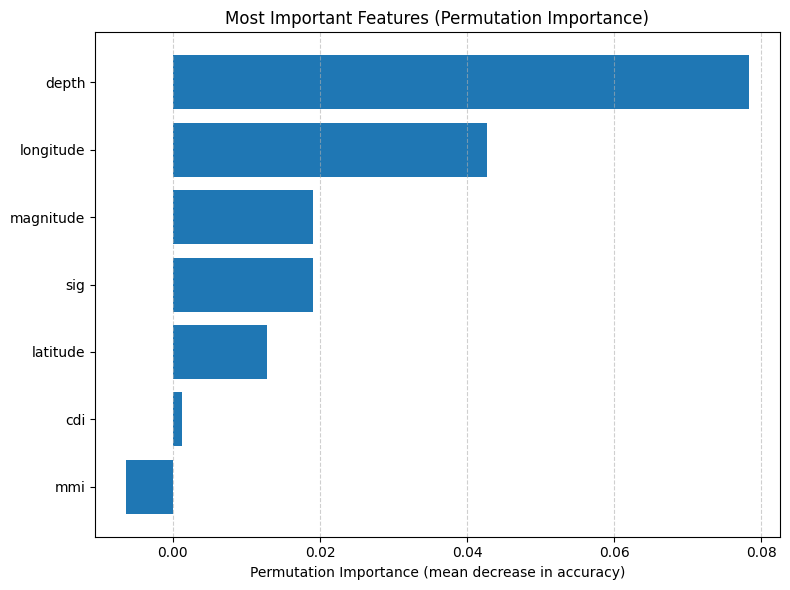

['tsunami_gradient_boosting_model.joblib']

In [38]:
# Determine Feature Importance and Save Model
clf = best_model.named_steps["clf"]


result = permutation_importance(
    best_model, X_test, y_test,
    n_repeats=10,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

fi_series = pd.Series(result.importances_mean, index=FEATURE_COLS)
fi_series = fi_series.sort_values(ascending=False)

display(fi_series.head(15))
top_features = fi_series.head(top_n)

plt.figure(figsize=(8, 6))
plt.barh(top_features.index, top_features.values)
plt.xlabel("Permutation Importance (mean decrease in accuracy)")
plt.title(f"Most Important Features (Permutation Importance)")
plt.gca().invert_yaxis()
plt.grid(axis="x", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

joblib.dump(best_model, "tsunami_gradient_boosting_model.joblib")

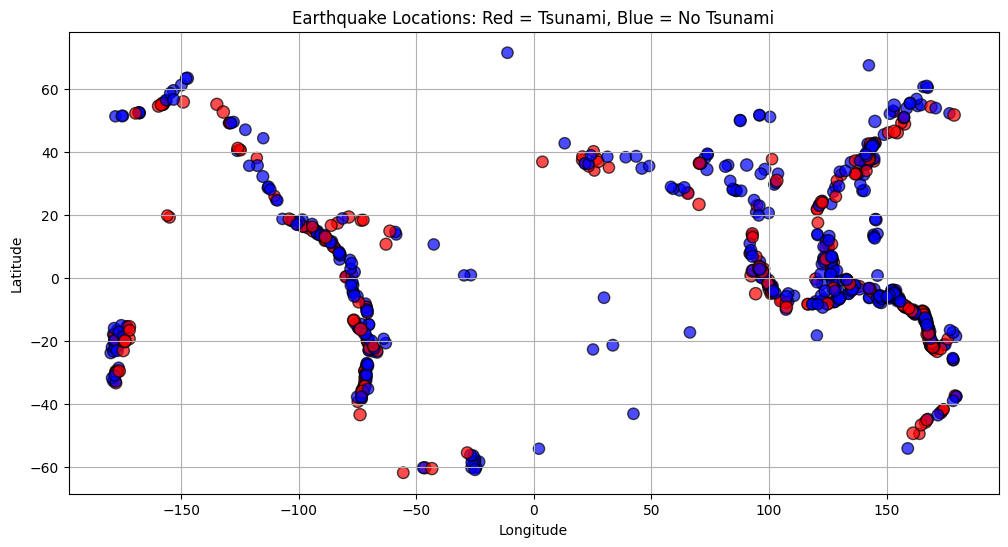

In [53]:
#Scatter Plot of Longitude/Latitude tsunami likelihoods

# Scatter plot of earthquakes
plt.figure(figsize=(12,6))

# Color by tsunami occurrence
colors = df['tsunami'].map({1: 'red', 0: 'blue'})

# scale marker size by magnitude
sizes = df['magnitude'] * 10 

plt.scatter(df['longitude'], df['latitude'], c=colors, s=sizes, alpha=0.7, edgecolor='k')

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Earthquake Locations: Red = Tsunami, Blue = No Tsunami')
plt.grid(True)
plt.show()

In [49]:
import folium

# Center map roughly in the middle of your data
center_lat = df['latitude'].mean()
center_lon = df['longitude'].mean()

m = folium.Map(location=[center_lat, center_lon], zoom_start=2)

# Add points
for _, row in df.iterrows():
    color = 'red' if row['tsunami'] == 1 else 'blue'
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=4,
        color=color,
        fill=True,
        fill_opacity=0.7,
        popup=f"Magnitude: {row['magnitude']}, Tsunami: {row['tsunami']}"
    ).add_to(m)

# Display in notebook
m

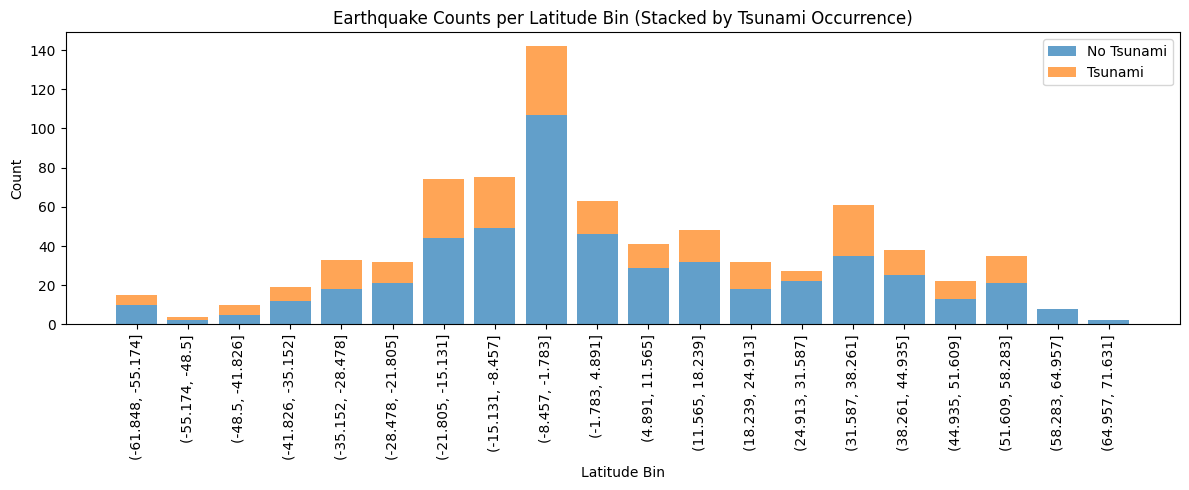

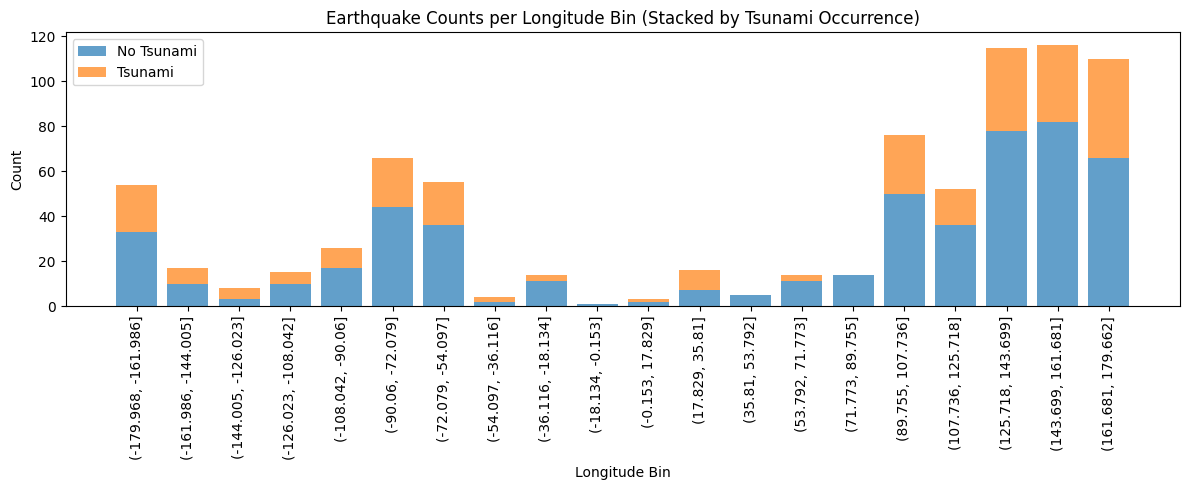

In [58]:
# Create Lat/Lon bins
BIN_SIZE = 20

lat_bins = np.linspace(df["latitude"].min(), df["latitude"].max(), BIN_SIZE + 1)
df["lat_bin"] = pd.cut(df["latitude"], bins=lat_bins)
lat_counts = df.groupby(["lat_bin", "tsunami"]).size().unstack(fill_value=0)

lon_bins = np.linspace(df["longitude"].min(), df["longitude"].max(), BIN_SIZE + 1)
df["lon_bin"] = pd.cut(df["longitude"], bins=lon_bins)
lon_counts = df.groupby(["lon_bin", "tsunami"]).size().unstack(fill_value=0)

#Display Plots
plt.figure(figsize=(12, 5))
plt.bar(range(len(lat_counts)), lat_counts[0], label="No Tsunami", alpha=0.7)
plt.bar(range(len(lat_counts)), lat_counts[1], bottom=lat_counts[0], label="Tsunami", alpha=0.7)

plt.xticks(range(len(lat_counts)), [str(b) for b in lat_counts.index], rotation=90)
plt.title("Earthquake Counts per Latitude Bin (Stacked by Tsunami Occurrence)")
plt.xlabel("Latitude Bin")
plt.ylabel("Count")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 5))
plt.bar(range(len(lon_counts)), lon_counts[0], label="No Tsunami", alpha=0.7)
plt.bar(range(len(lon_counts)), lon_counts[1], bottom=lon_counts[0], label="Tsunami", alpha=0.7)

plt.xticks(range(len(lon_counts)), [str(b) for b in lon_counts.index], rotation=90)
plt.title("Earthquake Counts per Longitude Bin (Stacked by Tsunami Occurrence)")
plt.xlabel("Longitude Bin")
plt.ylabel("Count")
plt.legend()
plt.tight_layout()
plt.show()

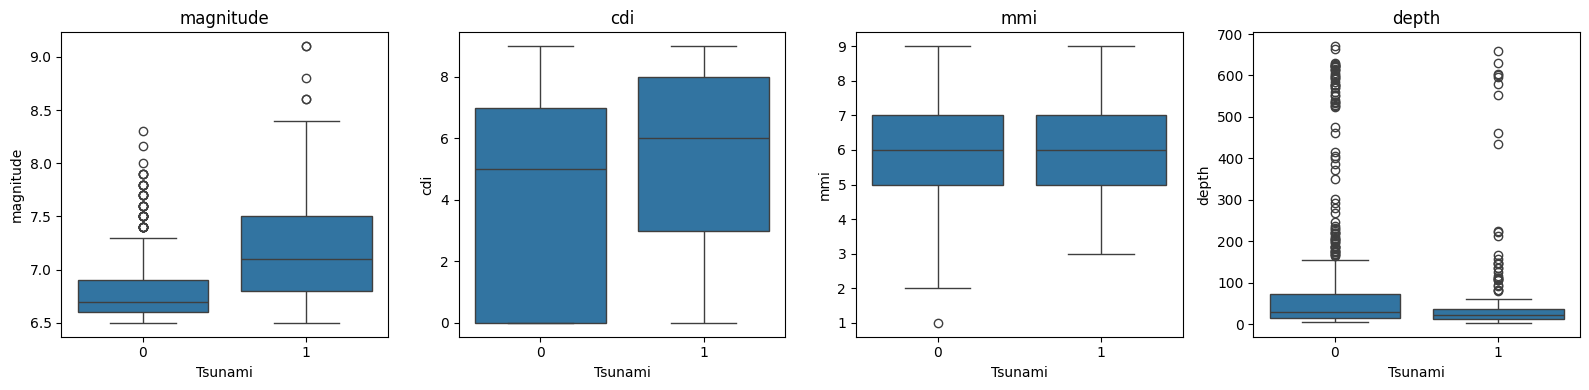

In [51]:
#violin plot comparing the feature effectiness of depth, magnitude, cdi, and mmi.

import seaborn as sns

features = ['magnitude', 'cdi', 'mmi', 'depth']

plt.figure(figsize=(16, 4))
for i, feature in enumerate(features, 1):
    plt.subplot(1, 4, i)
    sns.boxplot(x='tsunami', y=feature, data=df)
    plt.title(feature)
    plt.xlabel('Tsunami')
plt.tight_layout()
plt.show()

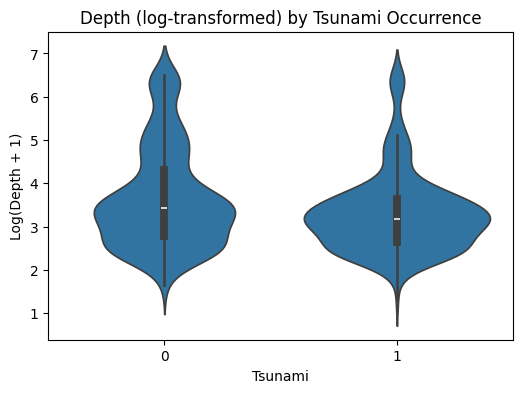

In [52]:
#Redo the depth violin plot to better display distribution.


plt.figure(figsize=(6,4))
sns.violinplot(
    x='tsunami', 
    y=np.log1p(df['depth']),  # log1p = log(1 + depth) to handle 0 values
    data=df
)
plt.ylabel('Log(Depth + 1)')
plt.xlabel('Tsunami')
plt.title('Depth (log-transformed) by Tsunami Occurrence')
plt.show()